In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import scipy.stats as stats
from scipy.stats import norm, levene
from scipy.optimize import minimize, Bounds, LinearConstraint

In [3]:
file_location = 'C:\\Asset_prices_EM.csv'

In [4]:
f = pd.read_csv(file_location)
df = pd.DataFrame(f)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206 entries, 0 to 2205
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2206 non-null   object 
 1   spx        2142 non-null   float64
 2   us_gov     2131 non-null   float64
 3   eafe       2206 non-null   float64
 4   eu_gov     2159 non-null   float64
 5   credit     2206 non-null   float64
 6   gsci       2145 non-null   float64
 7   em_stx     2206 non-null   float64
 8   em_gov     2206 non-null   float64
 9   ch_gov_pb  1131 non-null   float64
 10  ch_gov     2206 non-null   float64
dtypes: float64(10), object(1)
memory usage: 189.7+ KB


In [6]:
df.head(10)

,Date,spx,us_gov,eafe,eu_gov,credit,gsci,em_stx,em_gov,ch_gov_pb,ch_gov
0,31/12/2020,7759.3501,2559.40,6916.455,311.98,303.9205,1976.9550,624.13,151.7242,242.3558,233.8489
1,30/12/2020,7709.1001,2556.95,6961.396,313.62,303.9507,1969.0790,623.05,151.8620,242.6696,234.2104
2,29/12/2020,7697.9302,2555.40,6953.685,312.22,303.1986,1953.8870,612.29,151.4784,242.3388,233.7852
3,28/12/2020,7715.1001,2555.88,6870.170,NaN,302.5604,1940.1130,604.62,150.9539,241.8816,233.2795
4,24/12/2020,7648.3901,2555.72,6819.117,309.76,302.3302,1953.8010,605.19,151.1945,241.7913,233.1502
5,23/12/2020,7620.6299,2551.84,6804.098,309.82,301.9259,1953.1680,607.37,150.7744,241.6541,232.9998
6,22/12/2020,7614.8301,2557.71,6736.779,310.55,302.0893,1924.8990,602.80,150.6366,241.1822,232.5300
7,21/12/2020,7630.0698,2553.24,6742.103,311.46,302.0359,1941.7531,606.80,150.8188,240.6895,231.9863
8,18/12/2020,7659.7500,2551.40,6862.564,311.90,302.4120,1969.9360,612.27,151.9746,240.7125,232.0603
9,17/12/2020,7686.1802,2554.17,6893.679,312.40,302.7751,1953.0040,614.47,152.1365,240.9841,232.2942


In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [8]:
# Backward filling null values (filling with the previous known value in the time series order)
df.fillna(method='bfill', inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206 entries, 0 to 2205
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2206 non-null   datetime64[ns]
 1   spx        2206 non-null   float64       
 2   us_gov     2206 non-null   float64       
 3   eafe       2206 non-null   float64       
 4   eu_gov     2206 non-null   float64       
 5   credit     2206 non-null   float64       
 6   gsci       2206 non-null   float64       
 7   em_stx     2206 non-null   float64       
 8   em_gov     2206 non-null   float64       
 9   ch_gov_pb  2205 non-null   float64       
 10  ch_gov     2206 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 189.7 KB


# Feature Engineering

Use __simple percentage__ daily returns for the multi-asset portfolio optimization procedure, as typical.

In [10]:
df_port = df.drop(['Date'], axis=1)

In [11]:
# Transform DataFrame into log daily returns, with a rising time series 
df_port_log = np.log(df_port/df_port.shift(-1))

In [12]:
# Transform DataFrame into simple percentage daily returns, with a rising time series 
df_port = df_port.pct_change(-1)

In [13]:
df_port['Date'] = df.Date
df_port_log['Date'] = df.Date

In [14]:
df_port

,spx,us_gov,eafe,eu_gov,credit,gsci,em_stx,em_gov,ch_gov_pb,ch_gov,Date
0,0.006518,0.000958,-0.006456,-0.005229,-0.000099,0.004000,0.001733,-0.000907,-0.001293,-0.001543,2020-12-31
1,0.001451,0.000607,0.001109,0.004484,0.002481,0.007775,0.017573,0.002532,0.001365,0.001819,2020-12-30
2,-0.002225,-0.000188,0.012156,0.007942,0.002109,0.007100,0.012686,0.003475,0.001890,0.002168,2020-12-29
3,0.008722,0.000063,0.007487,0.000000,0.000761,-0.007006,-0.000942,-0.001591,0.000373,0.000555,2020-12-28
4,0.003643,0.001520,0.002207,-0.000194,0.001339,0.000324,-0.003589,0.002786,0.000568,0.000645,2020-12-24
...,...,...,...,...,...,...,...,...,...,...,...
2201,0.000000,0.000000,-0.003012,-0.007707,-0.001530,0.000000,0.000291,-0.004211,0.000000,0.000769,2012-07-04
2202,0.006461,-0.002400,0.009400,0.003981,-0.000242,0.034495,0.016365,0.007538,0.000000,-0.000512,2012-07-03
2203,0.002521,0.003976,0.006000,-0.004586,0.002225,-0.003398,0.004372,0.002426,0.000000,0.001140,2012-07-02
2204,0.024963,-0.003763,0.036236,0.029281,0.004963,0.056336,0.033875,0.022926,0.000000,0.001810,2012-06-29


In [15]:
# Delete last row of null values
df_port = df_port.iloc[:-1]
df_port_log = df_port_log.iloc[:-1]

In [16]:
df_port.describe()

,spx,us_gov,eafe,eu_gov,credit,gsci,em_stx,em_gov,ch_gov_pb,ch_gov
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,0.000605,0.000101,0.000344,0.000176,0.000161,-0.000267,0.000297,0.000066,0.000143,0.000133
std,0.010470,0.002411,0.008815,0.005344,0.002688,0.012928,0.009508,0.005644,0.002395,0.002223
min,-0.119799,-0.018624,-0.103600,-0.032431,-0.033523,-0.117701,-0.067026,-0.045603,-0.019705,-0.018817
25%,-0.002950,-0.001194,-0.003750,-0.002608,-0.001113,-0.006281,-0.004662,-0.002972,0.000000,-0.000890
50%,0.000519,0.000081,0.000508,0.000033,0.000238,0.000065,0.000675,0.000150,0.000000,0.000097
75%,0.005052,0.001431,0.004862,0.003173,0.001657,0.006074,0.005589,0.003265,0.000103,0.001164
max,0.093936,0.016819,0.071596,0.031322,0.016849,0.079142,0.057422,0.035202,0.025323,0.012974


In [17]:
df_port_log.describe()

,spx,us_gov,eafe,eu_gov,credit,gsci,em_stx,em_gov,ch_gov_pb,ch_gov
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2204.000000,2205.000000
mean,0.000550,0.000098,0.000305,0.000162,0.000157,-0.000351,0.000252,0.000050,0.000140,0.000130
std,0.010513,0.002411,0.008856,0.005344,0.002693,0.012998,0.009533,0.005651,0.002391,0.002223
min,-0.127605,-0.018800,-0.109368,-0.032968,-0.034098,-0.125224,-0.069378,-0.046676,-0.019902,-0.018997
25%,-0.002955,-0.001195,-0.003757,-0.002612,-0.001114,-0.006301,-0.004673,-0.002977,0.000000,-0.000890
50%,0.000519,0.000081,0.000508,0.000033,0.000238,0.000065,0.000675,0.000150,0.000000,0.000097
75%,0.005039,0.001430,0.004850,0.003168,0.001656,0.006056,0.005574,0.003260,0.000103,0.001163
max,0.089782,0.016679,0.069149,0.030841,0.016709,0.076166,0.055834,0.034596,0.025008,0.012890


_ch_gov_pb_ only has daily data from 4 May 2012. Need to use the China Treasury bonds daily returns prior to that date from _ch_gov_.

In [18]:
df_port.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   spx        2205 non-null   float64       
 1   us_gov     2205 non-null   float64       
 2   eafe       2205 non-null   float64       
 3   eu_gov     2205 non-null   float64       
 4   credit     2205 non-null   float64       
 5   gsci       2205 non-null   float64       
 6   em_stx     2205 non-null   float64       
 7   em_gov     2205 non-null   float64       
 8   ch_gov_pb  2205 non-null   float64       
 9   ch_gov     2205 non-null   float64       
 10  Date       2205 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 189.6 KB


In [19]:
df_port_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   spx        2205 non-null   float64       
 1   us_gov     2205 non-null   float64       
 2   eafe       2205 non-null   float64       
 3   eu_gov     2205 non-null   float64       
 4   credit     2205 non-null   float64       
 5   gsci       2205 non-null   float64       
 6   em_stx     2205 non-null   float64       
 7   em_gov     2205 non-null   float64       
 8   ch_gov_pb  2204 non-null   float64       
 9   ch_gov     2205 non-null   float64       
 10  Date       2205 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 189.6 KB


In [20]:
# Function to create column of Chinese bond returns using the purely Treasury index...
# before 04 May 2016, and Treasury+Policy banks index afterwards

def subs(row):
    if row['Date'] < pd.to_datetime('2016-11-04'):
        val = row['ch_gov']
    else:
        val = row['ch_gov_pb']
    return val

df_port['ch_gov'] = df_port.apply(subs, axis=1)
df_port_log['ch_gov'] = df_port_log.apply(subs, axis=1)

C:\Users\camb7\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [21]:
df_port.set_index('Date', inplace=True)
df_port_log.set_index('Date', inplace=True)

In [22]:
df_port = df_port.drop(['ch_gov_pb'], axis=1)
df_port_log = df_port_log.drop(['ch_gov_pb'], axis=1)

In [23]:
# Setting the portfolio analysis start date to be 5 years from the final data point
ini_date = '2013-01-01'
df_port = df_port.loc[df_port.index >= ini_date]
df_port_log = df_port_log.loc[df_port_log.index >= ini_date]

# EDA

In [24]:
# Final DataFrame for the portfolio optimization
df_port.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2073 entries, 2020-12-31 to 2013-01-02
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     2073 non-null   float64
 1   us_gov  2073 non-null   float64
 2   eafe    2073 non-null   float64
 3   eu_gov  2073 non-null   float64
 4   credit  2073 non-null   float64
 5   gsci    2073 non-null   float64
 6   em_stx  2073 non-null   float64
 7   em_gov  2073 non-null   float64
 8   ch_gov  2073 non-null   float64
dtypes: float64(9)
memory usage: 162.0 KB


In [25]:
df_port.describe()

,spx,us_gov,eafe,eu_gov,credit,gsci,em_stx,em_gov,ch_gov
count,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000
mean,0.000602,0.000107,0.000283,0.000124,0.000138,-0.000351,0.000235,0.000015,0.000138
std,0.010624,0.002441,0.008780,0.005283,0.002731,0.013017,0.009582,0.005700,0.002248
min,-0.119799,-0.018624,-0.103600,-0.032431,-0.033523,-0.117701,-0.067026,-0.045603,-0.018817
25%,-0.002929,-0.001208,-0.003768,-0.002597,-0.001147,-0.006442,-0.004758,-0.003025,-0.000890
50%,0.000581,0.000078,0.000508,0.000000,0.000234,0.000000,0.000637,0.000117,0.000100
75%,0.005121,0.001441,0.004760,0.003058,0.001657,0.006074,0.005643,0.003286,0.001153
max,0.093936,0.016819,0.071596,0.031322,0.016849,0.079142,0.057422,0.035202,0.012974


In [26]:
df_port_log.describe()

,spx,us_gov,eafe,eu_gov,credit,gsci,em_stx,em_gov,ch_gov
count,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000
mean,0.000546,0.000104,0.000244,0.000110,0.000134,-0.000437,0.000189,-0.000002,0.000136
std,0.010670,0.002441,0.008826,0.005285,0.002737,0.013094,0.009610,0.005709,0.002248
min,-0.127605,-0.018800,-0.109368,-0.032968,-0.034098,-0.125224,-0.069378,-0.046676,-0.018997
25%,-0.002933,-0.001208,-0.003776,-0.002600,-0.001148,-0.006463,-0.004769,-0.003030,-0.000890
50%,0.000581,0.000078,0.000508,0.000000,0.000234,0.000000,0.000637,0.000117,0.000100
75%,0.005108,0.001440,0.004749,0.003054,0.001656,0.006056,0.005627,0.003281,0.001152
max,0.089782,0.016679,0.069149,0.030841,0.016709,0.076166,0.055834,0.034596,0.012890


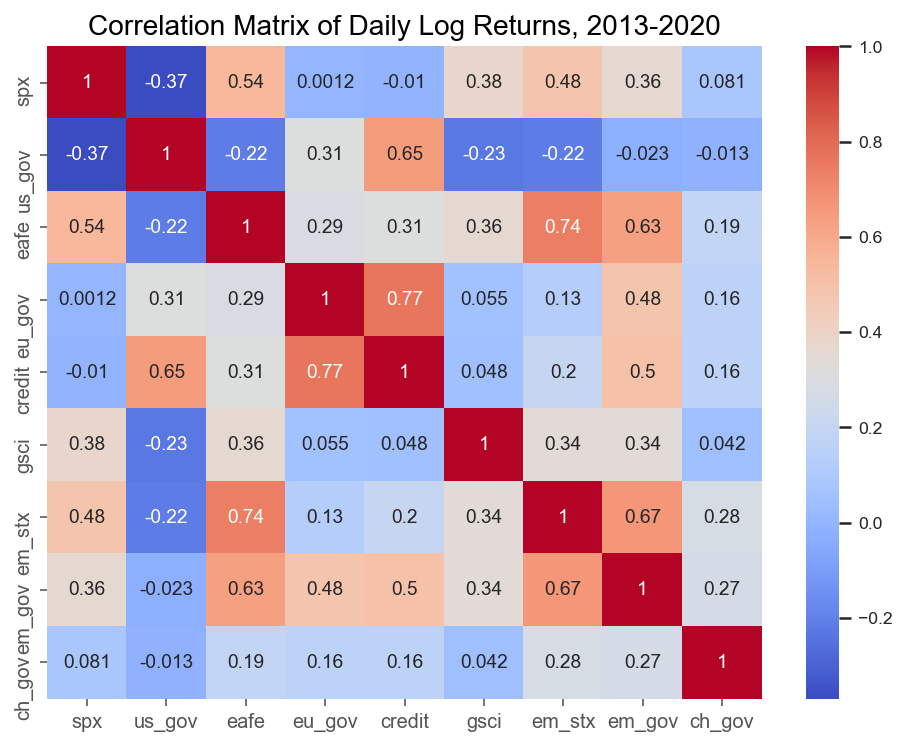

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.set(font_scale=0.8)
sns.heatmap(df_port_log.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix of Daily Log Returns, 2013-2020", fontsize=14)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10)
plt.show()

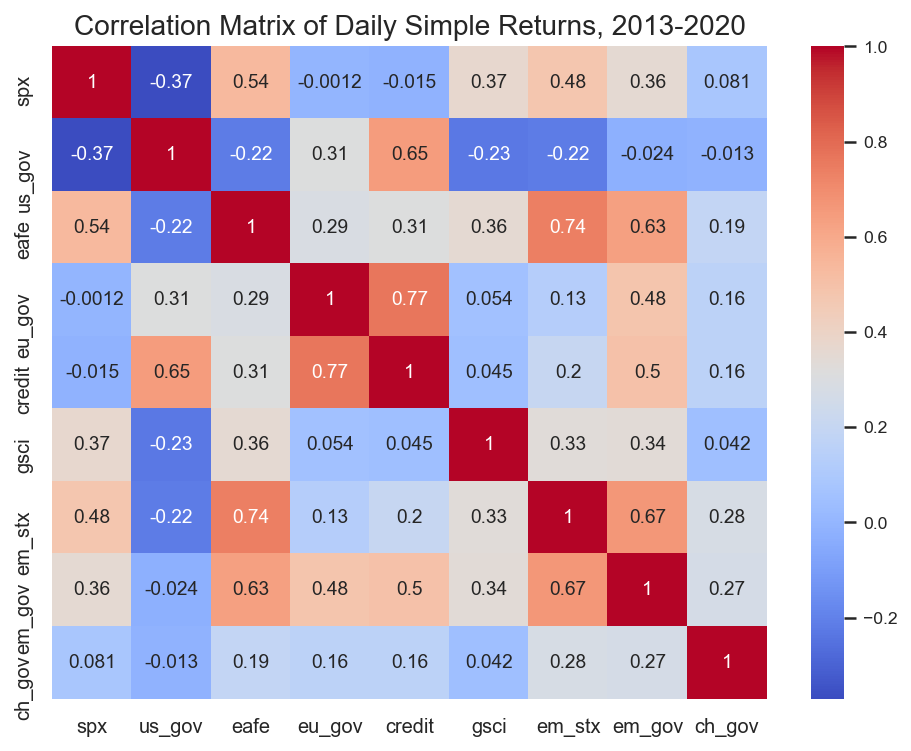

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.set(font_scale=0.8)
sns.heatmap(df_port.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix of Daily Simple Returns, 2013-2020", fontsize=14)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10)
plt.show()

### Capital market assumptions

To undertake the **mean-variance optimization** procedure, we need the following:
+ the portfolio's variance-covariance matrix;
+ the expected return from each asset class; and
+ an initial set of weights for the asset classes that sum to 1.

The **expected returns** are taken from *Blackrock Institute's* 10-year capital market assumptions dated February 2021, except for commodities, which is from *JP Morgan Asset Management's* 2021 capital market assumptions.

### Generating the variance-covariance matrix

In [29]:
# Optimization inputs
# Creating a DataFrame with the mean returns as the first column
factor_moments = pd.DataFrame(np.mean(df_port, axis=0), columns=['return'])
# Second column is volatility of the assets
factor_moments['volatility'] = np.diag(df_port.cov())**0.5*(253**0.5) #253 trading days in year
cov =  df_port.cov()

In [30]:
# Covariance matrix with the individual asset's variances on the diagonal
cov

,spx,us_gov,eafe,eu_gov,credit,gsci,em_stx,em_gov,ch_gov
spx,1.128697e-04,-9.595443e-06,0.000050,-6.503813e-08,-4.274104e-07,0.000051,0.000049,2.166338e-05,1.932443e-06
us_gov,-9.595443e-06,5.956051e-06,-0.000005,4.005755e-06,4.313395e-06,-0.000007,-0.000005,-3.318456e-07,-6.902862e-08
eafe,5.015213e-05,-4.677738e-06,0.000077,1.341156e-05,7.472915e-06,0.000041,0.000062,3.158001e-05,3.694398e-06
eu_gov,-6.503813e-08,4.005755e-06,0.000013,2.791491e-05,1.104622e-05,0.000004,0.000007,1.448789e-05,1.924646e-06
credit,-4.274104e-07,4.313395e-06,0.000007,1.104622e-05,7.458551e-06,0.000002,0.000005,7.759231e-06,1.006991e-06
gsci,5.142619e-05,-7.184489e-06,0.000041,3.690139e-06,1.591467e-06,0.000169,0.000041,2.499606e-05,1.242859e-06
em_stx,4.890828e-05,-5.105904e-06,0.000062,6.515264e-06,5.314298e-06,0.000041,0.000092,3.641932e-05,6.029775e-06
em_gov,2.166338e-05,-3.318456e-07,0.000032,1.448789e-05,7.759231e-06,0.000025,0.000036,3.248772e-05,3.436561e-06
ch_gov,1.932443e-06,-6.902862e-08,0.000004,1.924646e-06,1.006991e-06,0.000001,0.000006,3.436561e-06,5.054896e-06


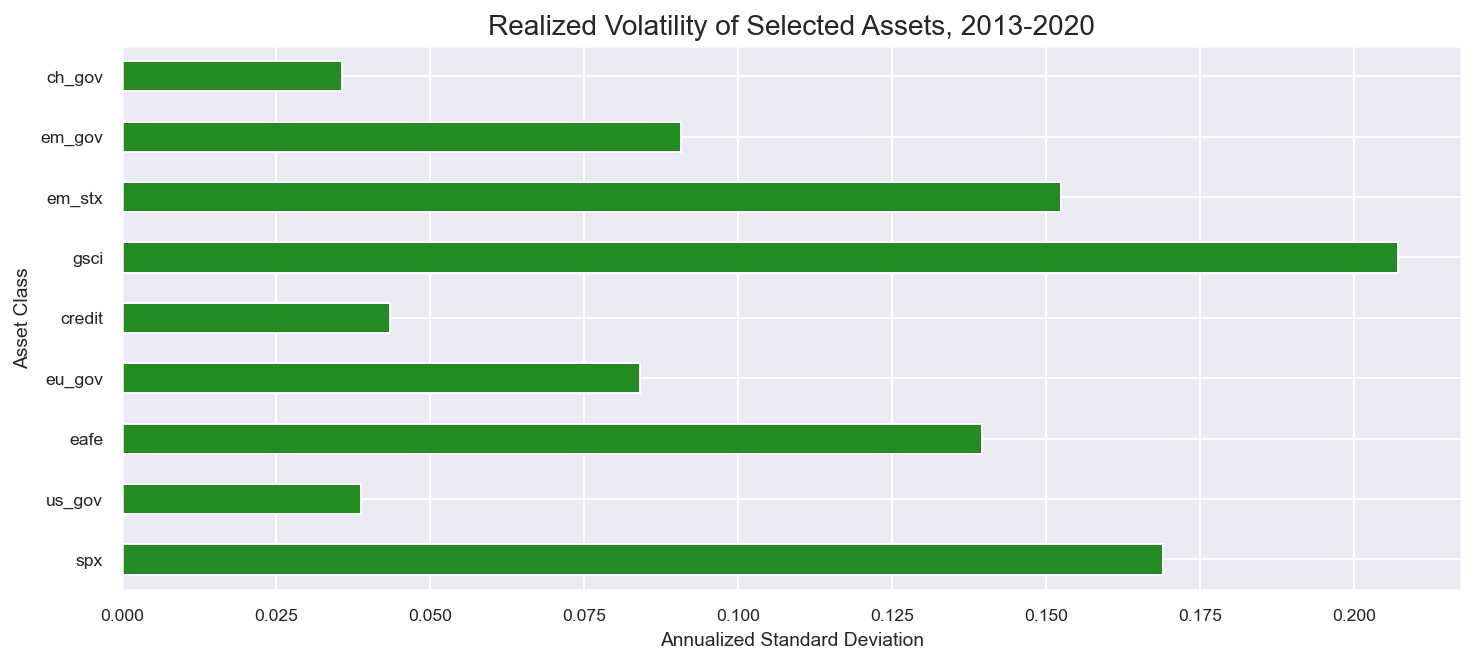

In [31]:
ax = factor_moments['volatility'].plot(kind='barh', color='forestgreen', figsize=(12,5))
ax.set_xlabel("Annualized Standard Deviation")
ax.set_ylabel("Asset Class")
ax.set_title("Realized Volatility of Selected Assets, 2013-2020", fontsize=14)
plt.show()

In [32]:
ecov_all = np.array(cov)

In [33]:
# Enter expected variances, which are annualized standard deviations divided by square root of 253
expected_variance = [0.0001169328, 0.0000119565, 0.0001076087, 0.0000115257, 0.0000115257, 
                     0.0001024545, 0.0001793241, 0.0000278893, 0.0000063241]

In [34]:
np.fill_diagonal(ecov_all, expected_variance)

In [35]:
# The Variaance-Covariance matrix with the expected variances on the diagonal and the historical covariances
ecov_all

array([[ 1.16932800e-04, -9.59544307e-06,  5.01521261e-05,
        -6.50381327e-08, -4.27410370e-07,  5.14261930e-05,
         4.89082751e-05,  2.16633775e-05,  1.93244324e-06],
       [-9.59544307e-06,  1.19565000e-05, -4.67773756e-06,
         4.00575455e-06,  4.31339517e-06, -7.18448857e-06,
        -5.10590438e-06, -3.31845606e-07, -6.90286227e-08],
       [ 5.01521261e-05, -4.67773756e-06,  1.07608700e-04,
         1.34115622e-05,  7.47291546e-06,  4.07964155e-05,
         6.23131804e-05,  3.15800104e-05,  3.69439828e-06],
       [-6.50381327e-08,  4.00575455e-06,  1.34115622e-05,
         1.15257000e-05,  1.10462197e-05,  3.69013900e-06,
         6.51526419e-06,  1.44878891e-05,  1.92464640e-06],
       [-4.27410370e-07,  4.31339517e-06,  7.47291546e-06,
         1.10462197e-05,  1.15257000e-05,  1.59146681e-06,
         5.31429798e-06,  7.75923074e-06,  1.00699110e-06],
       [ 5.14261930e-05, -7.18448857e-06,  4.07964155e-05,
         3.69013900e-06,  1.59146681e-06,  1.024545

### Expected returns & initial weights

In [36]:
# Expected returns in the order of the df_port's column headings
# The number for "EU bonds" is derived from BI's euro expected return then translated... 
# into US dollars based on BI's implied average exchange rate factor

expected_returns = np.array([[ 0.063],  # US equities
                             [ 0.007],  # US bonds
                             [ 0.075],  # EAFE equities
                             [-0.004],  # EU bonds
                             [ 0.0025], # Credit
                             [ 0.023],  # Commodities
                             [ 0.072],  # EM equities
                             [ 0.034],  # EM bonds
                             [ 0.031]]) # China bonds

In [37]:
# Hypothetical initial asset class weights for a global investor
ini_weights = [0.25, 0.20, 0.15, 0.10, 0.05, 0.05, 0.10, 0.07, 0.03]

In [38]:
# Just to make sure that the initial asset weights sum to 100%
ini_weights = (np.array(ini_weights)/sum(ini_weights)).reshape(-1,1)
ini_weights

array([[0.25],
       [0.2 ],
       [0.15],
       [0.1 ],
       [0.05],
       [0.05],
       [0.1 ],
       [0.07],
       [0.03]])

### Various Functions

The **first** function is to calculate the portfolio's **risk-adjusted return**, which will go into the **optimization function**. 

The **second** function is to compute the portfolio's **expected return** and **annualized standard deviation**. 

The **third** function is to run the various equality of variances tests on **two** vectors.

In [39]:
def return_risk(weights, exp_returns, cov):
    '''
    Function to calculate the portfolio return divided by the standard deviation, or the risk-adjusted return.
    Inputs Numpy arrays.
    '''
    port_return = np.dot(weights, exp_returns)
    port_var = weights.dot(cov).dot(weights)
    return -((port_return.item())/(port_var.item())**0.5)


In [40]:
def port_profile(df_weights, exp_returns, cov):
    '''
    Function to generate the portfolio's expected returns, variances & annualized std deviation.
    Calculations are done using Numpy arrays.
    Outputs are a tuple holding the return & std deviation.
    '''   
    weights = df_weights.to_numpy()
    port_return = np.dot(weights.T, exp_returns)# compute the portfolio's expected return
    port_var = weights.T.dot(cov).dot(weights)  # compute the portfolio's expected variance                       
    port_vol = port_var**0.5*(253**0.5)         # compute the annualized standard deviation
    return port_return.item(), port_vol.item()  # tuple of single element from each array for return & std deviation


In [41]:
def var_tests(df_1, df_weights_1, df_2, df_weights_2):
    '''
    From each pair of a DataFrame of asset daily returns and a DataFrame of its weights, 
    the function calculates their respective variances,
    then runs the F-test & Levene's tests on these two variances.
    
    The two portfolios and their weights must be paired in the correct order.
    '''
    x1 = np.dot(df_1.to_numpy(), df_weights_1.to_numpy()) # Transform the DataFrames to Numpy arrays
    x2 = np.dot(df_2.to_numpy(), df_weights_2.to_numpy())
    
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    
    n1 = len(x1)
    n2 = len(x2)
    
    # Run F-tests
    if v1 > v2:
        f = v1/v2
        p = 1 - stats.f.cdf(f, n1-1, n2-1) # Last two figures are the degrees of freedom of the two arrays
    else:
        f = v2/v1
        p = 1 - stats.f.cdf(f, n1-1, n2-1)

    if p < 0.05:
        print("Null hypothesis of equal variances is rejected according to the F-test")
    else:
        print("Null hypothesis of equal variances is not rejected according to the F-test")
    
    print(f"F-test statistic: {f:0.6f}")
    print(f"p-value: {p:0.6f}")

    # Run Levene's test using median
    l1, p1 = levene(x1.ravel(), x2.ravel(), center="median") # Flatten each Numpy array of variances
    if p1 < 0.05:
        print("Null hypothesis of equal variances is rejected according to the Levene(median) test")
    else:
        print("Null hypothesis of equal variances is not rejected according to the Levene(median) test")
    
    print(f"Levene's test statistic: {l1:0.6f}")
    print(f"p-value: {p1:0.6f}")
    
    # Run Levene's test using trimmed mean
    l2, p2 = levene(x1.ravel(), x2.ravel(), center="trimmed") # Flatten each Numpy array of variances
    if p2 < 0.05:
        print("Null hypothesis of equal variances is rejected according to the Levene(trimmed) test")
    else:
        print("Null hypothesis of equal variances is not rejected according to the Levene(trimmed) test")
    
    print(f"Levene's test statistic: {l2:0.6f}")
    print(f"p-value: {p2:0.6f}")
    

# Portfolio Optimization

Set **four portfolio constraints** and **one target return**, all in percentages. The **equality constraints for DM equities and EM equities** are taken from _Blackrock's_ hypothetical "UK multi-asset" fund (Feb 2021).

In [42]:
# For DM equity allocation
dm_equities = 0.46

In [43]:
# For EM equity allocation
em_equities = 0.07

In [44]:
# For DM bond allocation
dm_bonds = 0.20

In [45]:
# For EM bond allocation
em_bonds = 0.15

In [46]:
# Set portfolio target expected return, also for the hypothetical "UK multi-asset" fund
target_return = 0.045

### Optimization Function

In [47]:
# Portfolio optimization function
def optimizer(function, weights, returns, cov, target_return):
    # Portfolio bounds for each asset class
    port_bounds = Bounds(0.0, 1.0)
    
    port_constraints = ({'type': 'eq',
                        'fun': lambda weights: weights[0] + weights[2] - dm_equities}, #DM equities allocation
                        {'type': 'ineq',
                        'fun': lambda weights: dm_bonds - (weights[1] + weights[3])},  #Max DM bonds allocation
                        {'type': 'ineq',
                        'fun': lambda weights: weights[0] - 0.15},                     #Min US equity allocation
                        {'type': 'eq',
                        'fun': lambda weights: weights[6] - em_equities},              #EM equities allocation
                        {'type': 'ineq',
                        'fun': lambda weights: em_bonds - (weights[7] + weights[8])},  #Max EM bonds allocation
                        {'type': 'ineq',
                        'fun': lambda weights: 0.05 - weights[8]},                     #Max China bond allocation
                        {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1.0},                 #Total weights equal 100%
                        {'type': 'eq',
                        'fun': lambda weights: (weights.T@returns) - target_return})
                                                                         # Portfolio return equals the "target return"

    opt_weights = minimize(function, 
                           weights,
                           args=(returns, cov),
                           method='SLSQP',
                           bounds=port_bounds,
                           constraints=port_constraints)
    
    return opt_weights['x']


# Optimization With 2013-2020 Data

In [48]:
# Run optimizer to return an array of the optimized weights as "x"
x = optimizer(return_risk, ini_weights, expected_returns, ecov_all, target_return)

In [49]:
opt = pd.DataFrame(x, index=factor_moments.index, columns=['optimal_weights'])

In [50]:
# Confirmation that the various asset weights sum to 100%
opt.sum()

optimal_weights    1.0
dtype: float64

In [51]:
opt

,optimal_weights
spx,1.500000e-01
us_gov,2.000000e-01
eafe,3.100000e-01
eu_gov,9.492407e-15
credit,9.024390e-02
gsci,2.975610e-02
em_stx,7.000000e-02
em_gov,1.000000e-01
ch_gov,5.000000e-02


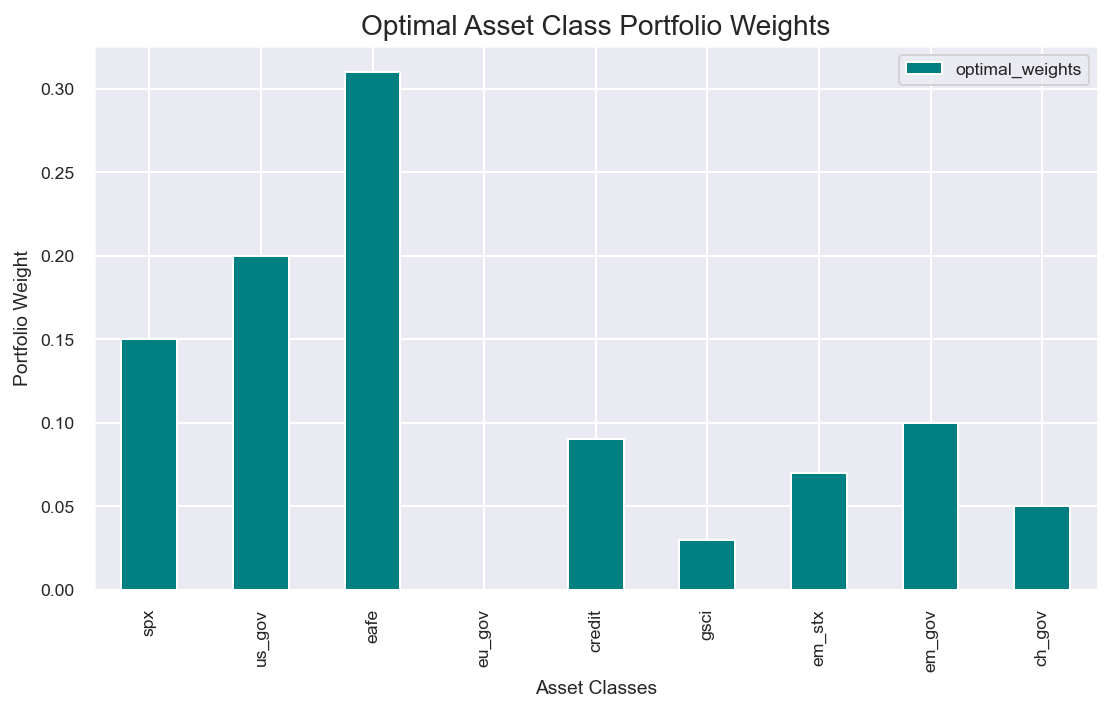

In [52]:
ax = opt.plot(kind='bar', color='teal', figsize=(9, 5))
ax.set_xlabel("Asset Classes")
ax.set_ylabel("Portfolio Weight")
ax.set_title("Optimal Asset Class Portfolio Weights", fontsize=14)
plt.show()

The optimization results recommend a the **max constraint allocation of 15%** to EM bonds with Chinese bonds taking the full 5% allocation, given the target return and various equity allocation constraints.

### Dropping EM bonds

In [53]:
# Dropping the Chinese bonds columns from the main DataFrame
df_port_xem = df_port.drop(['ch_gov'], axis=1)

In [54]:
# Setting max allocation to EM bonds of 5%
em_bonds_less = 0.05
dm_bonds_more = 0.20 # Keeping maximum DM bond allocation at 20%

In [55]:
# Drop Chinese bonds returns from the returns array
expected_returns_xem = expected_returns[:-1]

In [56]:
cov_xem =  df_port_xem.cov()

In [57]:
ecov_xem = np.array(cov_xem)

In [58]:
# Drop Chinese bonds variance from the list
expected_variance_xem = expected_variance[:-1]

In [59]:
np.fill_diagonal(ecov_xem, expected_variance_xem)

In [60]:
# Increasing the initial weights of US and EU bonds after reducing EM bonds
ini_weights_xem = [0.30, 0.15, 0.15, 0.13, 0.10, 0.05, 0.07, 0.05]
ini_weights_xem = (np.array(ini_weights_xem)/sum(ini_weights_xem)).reshape(-1,1)

In [61]:
# The same portfolio optimization function as above except for dropping Chinese bonds...
# and limiting overall EM bond exposure to a 5% maximum constraint
def optimizer_xem(function, weights, returns, cov, target_return):   
    port_bounds = Bounds(0.0, 1.0)

    port_constraints = ({'type': 'eq',
                        'fun': lambda weights: weights[0] + weights[2] - dm_equities},
                        {'type': 'ineq',
                        'fun': lambda weights: dm_bonds_more - (weights[1] + weights[3])},
                        {'type': 'ineq',
                        'fun': lambda weights: weights[0] - 0.15},  
                        {'type': 'eq',
                        'fun': lambda weights: weights[6] - em_equities}, 
                        {'type': 'ineq',
                        'fun': lambda weights: em_bonds_less - weights[7]},
                        {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1.0},
                        {'type': 'eq',
                        'fun': lambda weights: (weights.T@returns) - target_return})

    opt_weights = minimize(function, 
                           weights,
                           args=(returns, cov),
                           method='SLSQP',
                           bounds=port_bounds,
                           constraints=port_constraints)
    
    return opt_weights['x']


In [62]:
# Keeping the same target return and global equities allocations as original setting
x = optimizer_xem(return_risk, ini_weights_xem, expected_returns_xem, ecov_xem, target_return)

In [63]:
u = factor_moments.index[:-1]
opt_xem = pd.DataFrame(x, index=factor_moments.index[:-1], columns=['optimal_weights'])

In [64]:
opt_xem.sum()

optimal_weights    1.0
dtype: float64

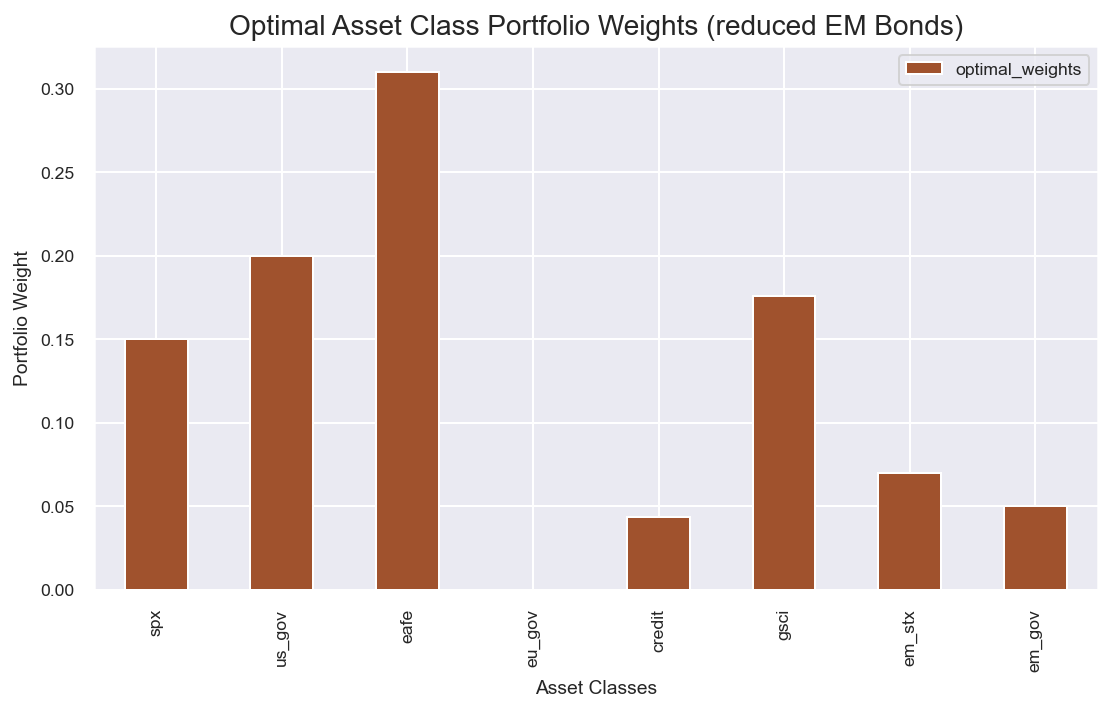

In [65]:
ax = opt_xem.plot(kind='bar', color='sienna', figsize=(9, 5))
ax.set_xlabel("Asset Classes")
ax.set_ylabel("Portfolio Weight")
ax.set_title("Optimal Asset Class Portfolio Weights (reduced EM Bonds)", fontsize=14)
plt.show()

In [66]:
# Getting the tuples of the expected return and variance
r1, s1 = port_profile(opt, expected_returns, cov)            
r2, s2 = port_profile(opt_xem, expected_returns_xem, cov_xem)

In [67]:
print(f"Expected return of all-asset portfolio: {r1:0.6f}")
print(f"Expected return of ex-EM bonds portfolio: {r2:0.6f}")
print(f"Standard deviation of all-asset portfolio: {s1:0.6f}")
print(f"Standard deviation of ex-EM bonds portfolio: {s2:0.6f}")

Expected return of all-asset portfolio: 0.045000
Expected return of ex-EM bonds portfolio: 0.045000
Standard deviation of all-asset portfolio: 0.077666
Standard deviation of ex-EM bonds portfolio: 0.091547


In [68]:
var_tests(df_port, opt, df_port_xem, opt_xem)

Null hypothesis of equal variances is rejected according to the F-test
F-test statistic: 1.389369
p-value: 0.000000
Null hypothesis of equal variances is rejected according to the Levene(median) test
Levene's test statistic: 21.682975
p-value: 0.000003
Null hypothesis of equal variances is rejected according to the Levene(trimmed) test
Levene's test statistic: 44.362504
p-value: 0.000000


We find that the optimized global multi-asset portfolio gives **full allocations** to EM sovereign bonds plus Chinese bonds. When we reduce EM bonds exposure in the optimization procedure, the optimizer substitutes it with **higher commodities exposure** and **reduced allocation to credit**. However, the EM-limited portfolio sees its **expected volatility rise**, namely the annualized standard deviation climbs from **7.77% to 9.15%**.

Raising the portfolio allocation to EM sovereign bonds cuts down the overall portfolio's expected volatility significantly, as indicated by the results from the various **equality of variances tests**, while providing the **same expected return**.

# Scenario 1: Using 2020 Covariance Matrix

The same procedure as above, but using the actual historical covariance matrix of daily returns from the **calendar year 2020**, which was marked by **elevated market volatility** as a result of the global Covid-19 crisis.

In [69]:
# Setting the analysis start date to be the last 1 year of daily data, given the dataset's last reading of 12/16/2020
ini_date = '2020-01-01'

In [70]:
df_port_2020 = df_port.loc[df_port.index >= ini_date]

In [71]:
df_port_2020

,spx,us_gov,eafe,eu_gov,credit,gsci,em_stx,em_gov,ch_gov
Date,,,,,,,,,
2020-12-31,0.006518,0.000958,-0.006456,-0.005229,-0.000099,0.004000,0.001733,-0.000907,-0.001293
2020-12-30,0.001451,0.000607,0.001109,0.004484,0.002481,0.007775,0.017573,0.002532,0.001365
2020-12-29,-0.002225,-0.000188,0.012156,0.007942,0.002109,0.007100,0.012686,0.003475,0.001890
2020-12-28,0.008722,0.000063,0.007487,0.000000,0.000761,-0.007006,-0.000942,-0.001591,0.000373
2020-12-24,0.003643,0.001520,0.002207,-0.000194,0.001339,0.000324,-0.003589,0.002786,0.000568
...,...,...,...,...,...,...,...,...,...
2020-01-08,0.004934,-0.003024,-0.003798,-0.003337,-0.002690,-0.025641,-0.003957,0.002541,-0.000182
2020-01-07,-0.002702,-0.000999,0.002304,-0.005288,-0.002343,-0.005080,0.002981,-0.003265,0.005251
2020-01-06,0.003538,-0.001538,-0.005247,0.002266,-0.000532,0.003018,-0.010057,0.000448,0.000301


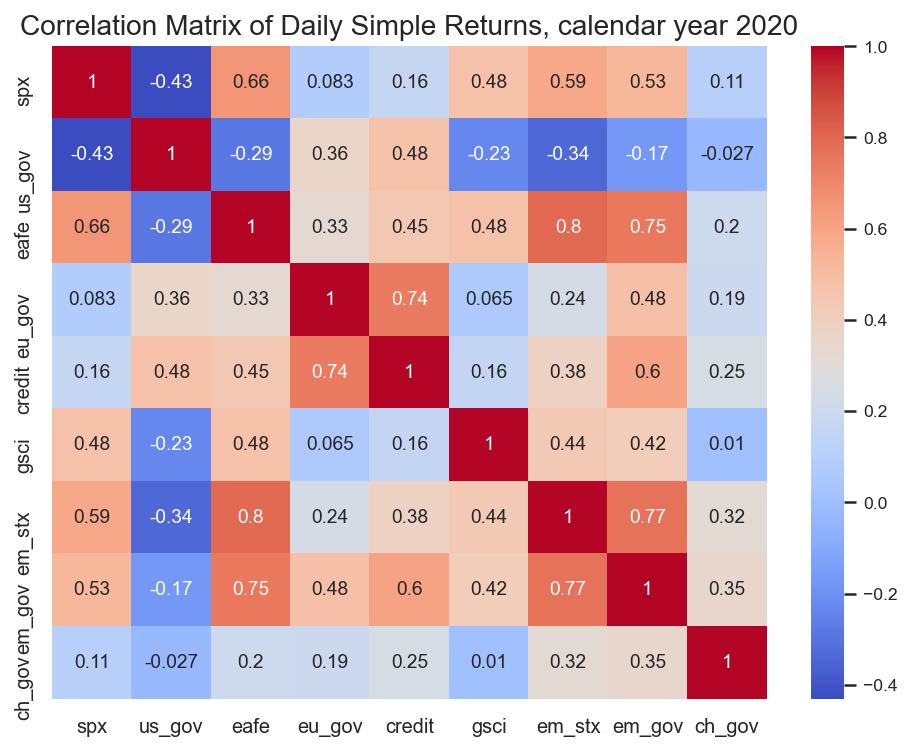

In [72]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.set(font_scale=0.8)
sns.heatmap(df_port_2020.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix of Daily Simple Returns, calendar year 2020", fontsize=14)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10)
plt.show()

In [73]:
cov_2020 =  df_port_2020.cov()

In [74]:
# Run optimizer as above using the new covariance matrix
x = optimizer(return_risk, ini_weights, expected_returns, cov_2020, target_return)

In [75]:
opt_2020 = pd.DataFrame(x, index=factor_moments.index, columns=['optimal_weights'])

In [76]:
# Confirmation that the various asset weights sum to 100%
opt_2020.sum()

optimal_weights    1.0
dtype: float64

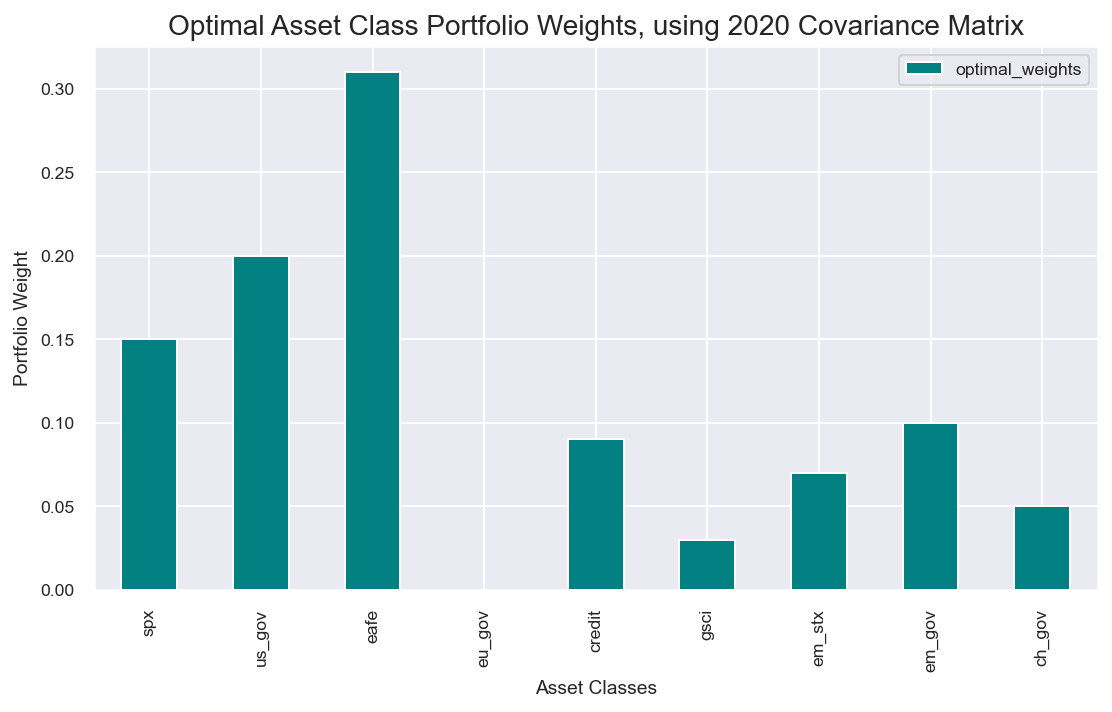

In [77]:
ax = opt_2020.plot(kind='bar', color='teal', figsize=(9, 5))
ax.set_xlabel("Asset Classes")
ax.set_ylabel("Portfolio Weight")
ax.set_title("Optimal Asset Class Portfolio Weights, using 2020 Covariance Matrix", fontsize=14)
plt.show()

## Dropping EM bonds

In [78]:
df_port_xem_2020 = df_port_xem.loc[df_port_xem.index >= ini_date]

In [79]:
df_port_xem_2020

,spx,us_gov,eafe,eu_gov,credit,gsci,em_stx,em_gov
Date,,,,,,,,
2020-12-31,0.006518,0.000958,-0.006456,-0.005229,-0.000099,0.004000,0.001733,-0.000907
2020-12-30,0.001451,0.000607,0.001109,0.004484,0.002481,0.007775,0.017573,0.002532
2020-12-29,-0.002225,-0.000188,0.012156,0.007942,0.002109,0.007100,0.012686,0.003475
2020-12-28,0.008722,0.000063,0.007487,0.000000,0.000761,-0.007006,-0.000942,-0.001591
2020-12-24,0.003643,0.001520,0.002207,-0.000194,0.001339,0.000324,-0.003589,0.002786
...,...,...,...,...,...,...,...,...
2020-01-08,0.004934,-0.003024,-0.003798,-0.003337,-0.002690,-0.025641,-0.003957,0.002541
2020-01-07,-0.002702,-0.000999,0.002304,-0.005288,-0.002343,-0.005080,0.002981,-0.003265
2020-01-06,0.003538,-0.001538,-0.005247,0.002266,-0.000532,0.003018,-0.010057,0.000448


In [80]:
cov_xem_2020 =  df_port_xem_2020.cov()

In [81]:
# Using the same ex-EM optimizer function as above
x = optimizer_xem(return_risk, ini_weights_xem, expected_returns_xem, cov_xem_2020, target_return)

In [82]:
opt_xem_2020 = pd.DataFrame(x, index=u, columns=['optimal_weights'])

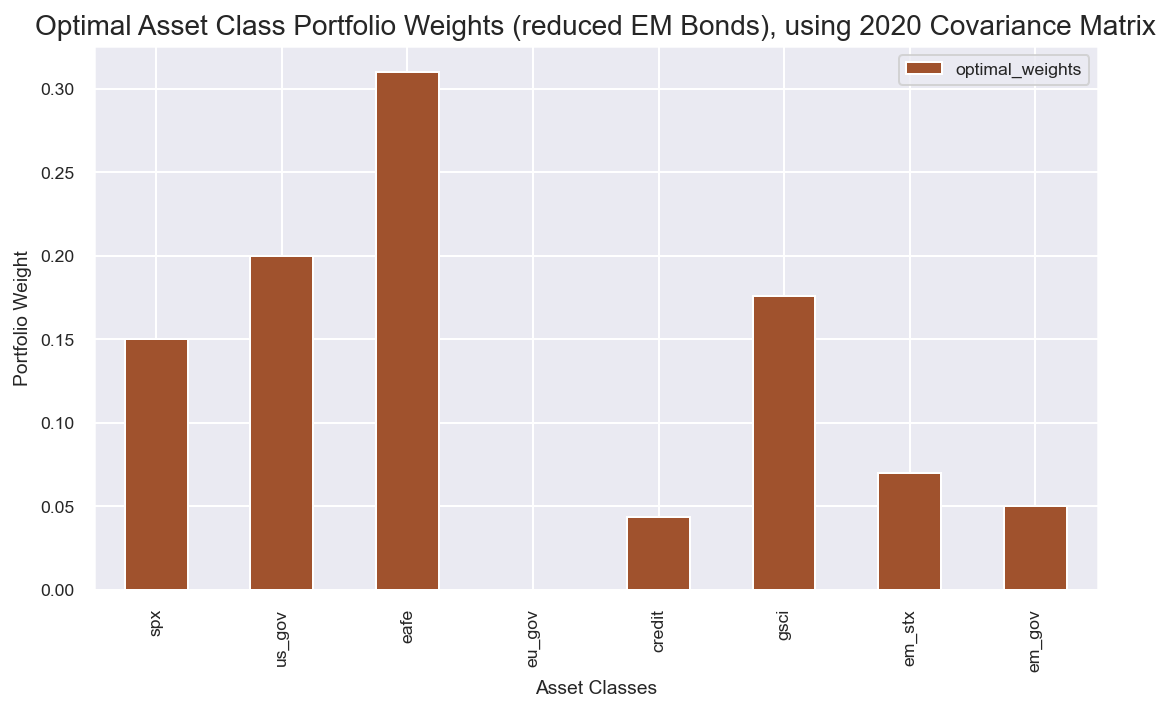

In [83]:
ax = opt_xem_2020.plot(kind='bar', color='sienna', figsize=(9, 5))
ax.set_xlabel("Asset Classes")
ax.set_ylabel("Portfolio Weight")
ax.set_title("Optimal Asset Class Portfolio Weights (reduced EM Bonds), using 2020 Covariance Matrix", fontsize=14)
plt.show()

In [84]:
r1_2020, s1_2020 = port_profile(opt_2020, expected_returns, cov_2020)
r2_2020, s2_2020 = port_profile(opt_xem_2020, expected_returns_xem, cov_xem_2020)

In [85]:
print(f"Expected return of all-asset portfolio: {r1_2020:0.6f}")
print(f"Expected return of ex-EM bonds portfolio: {r2_2020:0.6f}")
print(f"Standard deviation of all-asset portfolio: {s1_2020:0.6f}")
print(f"Standard deviation of ex-EM bonds portfolio: {s2_2020:0.6f}")

Expected return of all-asset portfolio: 0.045000
Expected return of ex-EM bonds portfolio: 0.045000
Standard deviation of all-asset portfolio: 0.141180
Standard deviation of ex-EM bonds portfolio: 0.166923


In [86]:
var_tests(df_port_2020, opt_2020, df_port_xem_2020, opt_xem_2020)

Null hypothesis of equal variances is rejected according to the F-test
F-test statistic: 1.397941
p-value: 0.003607
Null hypothesis of equal variances is not rejected according to the Levene(median) test
Levene's test statistic: 2.208270
p-value: 0.137881
Null hypothesis of equal variances is rejected according to the Levene(trimmed) test
Levene's test statistic: 5.046510
p-value: 0.025143


# Scenario 2: Using 2019 Covariance Matrix

Now we use the covariance matrix of daily returns from **calendar year 2019** when market volatility was generally **low and stable**.

In [87]:
# Set new dates for 2019 period
end_date = '2020-01-01'
ini_date = '2019-01-01'

In [88]:
df_port_2019 = df_port.loc[(df_port.index >= ini_date) & (df_port.index < end_date)]

In [89]:
df_port_2019

,spx,us_gov,eafe,eu_gov,credit,gsci,em_stx,em_gov,ch_gov
Date,,,,,,,,,
2019-12-31,0.003009,-0.001109,0.000468,0.001980,0.000739,-0.007600,-0.003344,0.001866,0.003463
2019-12-30,-0.005649,-0.000977,-0.003270,-0.000879,-0.000506,-0.001447,-0.000170,0.002185,0.001937
2019-12-27,0.000049,0.002110,0.006112,0.007975,0.003749,0.001347,0.007460,0.003564,-0.000184
2019-12-26,0.005221,0.000393,0.000651,0.000000,0.000553,0.008599,0.002824,0.001703,0.002976
2019-12-24,-0.000125,0.001624,0.001338,0.000259,0.001454,0.006857,-0.002304,0.001746,0.001639
...,...,...,...,...,...,...,...,...,...
2019-01-08,0.009719,-0.001896,0.005508,-0.003019,-0.001207,0.013147,-0.002372,-0.004017,0.000629
2019-01-07,0.007012,-0.000963,0.009229,0.003451,0.001906,0.006398,0.013479,0.004336,0.002276
2019-01-04,0.034334,-0.005712,0.015489,-0.000958,-0.002532,0.014762,0.016209,0.011889,0.001301


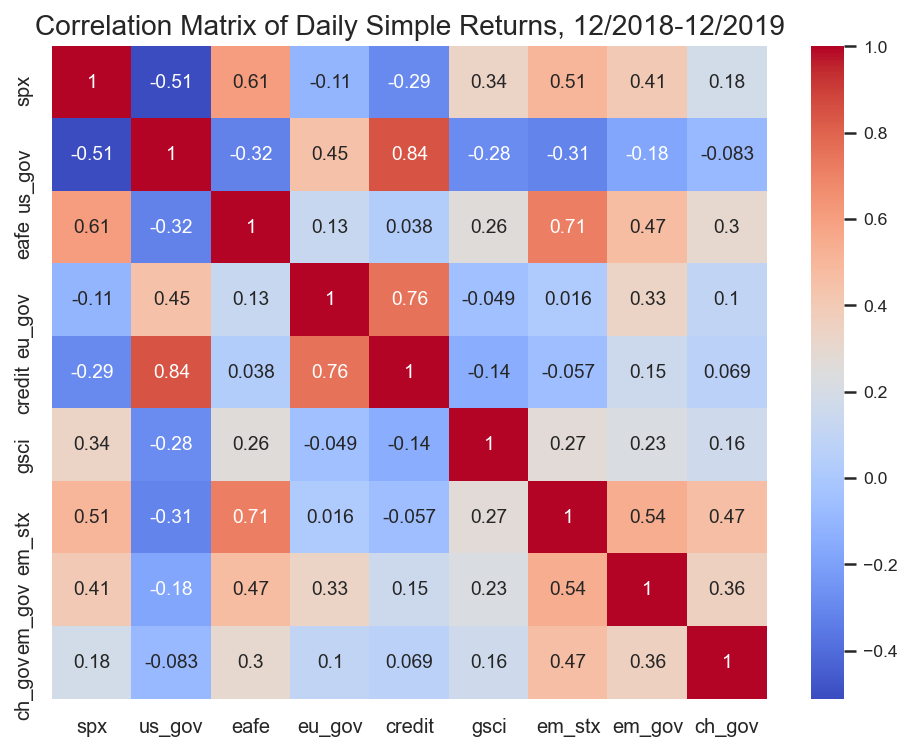

In [90]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.set(font_scale=0.8)
sns.heatmap(df_port_2019.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix of Daily Simple Returns, 12/2018-12/2019", fontsize=14)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=10)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=10)
plt.show()

In [91]:
cov_2019 =  df_port_2019.cov()

In [92]:
x = optimizer(return_risk, ini_weights, expected_returns, cov_2019, target_return)

In [93]:
opt_2019 = pd.DataFrame(x, index=factor_moments.index, columns=['optimal_weights'])

In [94]:
opt_2019.sum()

optimal_weights    1.0
dtype: float64

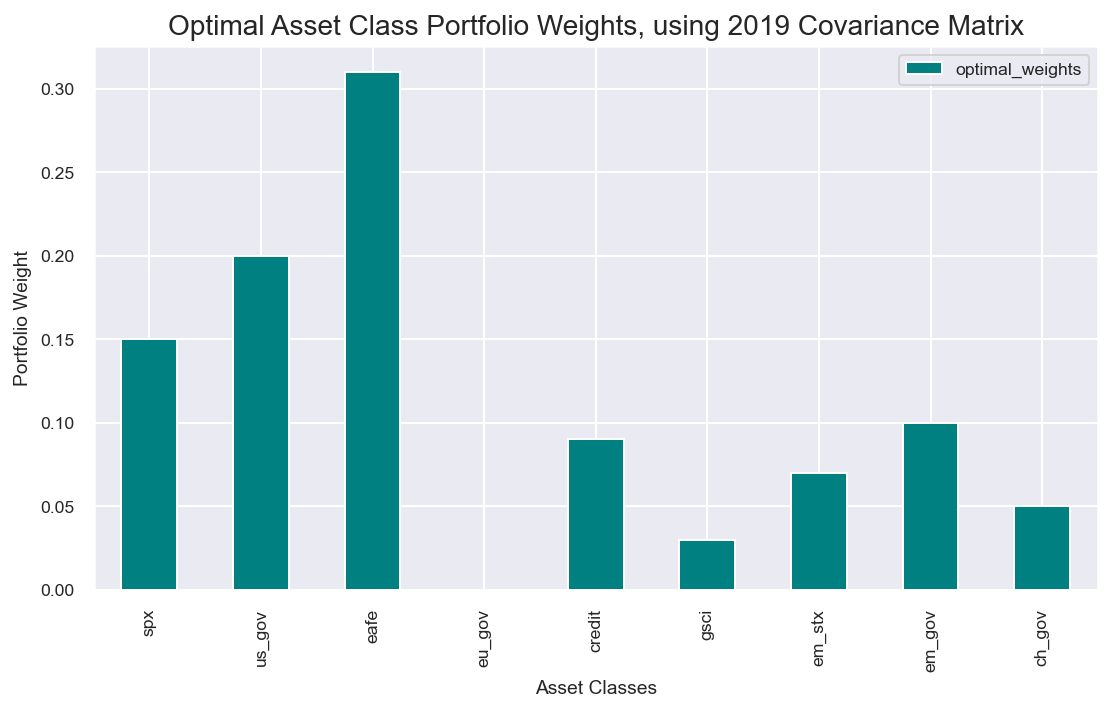

In [95]:
ax = opt_2019.plot(kind='bar', color='teal', figsize=(9, 5))
ax.set_xlabel("Asset Classes")
ax.set_ylabel("Portfolio Weight")
ax.set_title("Optimal Asset Class Portfolio Weights, using 2019 Covariance Matrix", fontsize=14)
plt.show()

### Dropping EM bonds

In [96]:
df_port_xem_2019 = df_port_xem.loc[(df_port_xem.index >= ini_date) & (df_port_xem.index < end_date)]

In [97]:
df_port_xem_2019

,spx,us_gov,eafe,eu_gov,credit,gsci,em_stx,em_gov
Date,,,,,,,,
2019-12-31,0.003009,-0.001109,0.000468,0.001980,0.000739,-0.007600,-0.003344,0.001866
2019-12-30,-0.005649,-0.000977,-0.003270,-0.000879,-0.000506,-0.001447,-0.000170,0.002185
2019-12-27,0.000049,0.002110,0.006112,0.007975,0.003749,0.001347,0.007460,0.003564
2019-12-26,0.005221,0.000393,0.000651,0.000000,0.000553,0.008599,0.002824,0.001703
2019-12-24,-0.000125,0.001624,0.001338,0.000259,0.001454,0.006857,-0.002304,0.001746
...,...,...,...,...,...,...,...,...
2019-01-08,0.009719,-0.001896,0.005508,-0.003019,-0.001207,0.013147,-0.002372,-0.004017
2019-01-07,0.007012,-0.000963,0.009229,0.003451,0.001906,0.006398,0.013479,0.004336
2019-01-04,0.034334,-0.005712,0.015489,-0.000958,-0.002532,0.014762,0.016209,0.011889


In [98]:
cov_xem_2019 =  df_port_xem_2019.cov()

In [99]:
x = optimizer_xem(return_risk, ini_weights_xem, expected_returns_xem, cov_xem_2019, target_return)

In [100]:
opt_xem_2019 = pd.DataFrame(x, index=u, columns=['optimal_weights'])

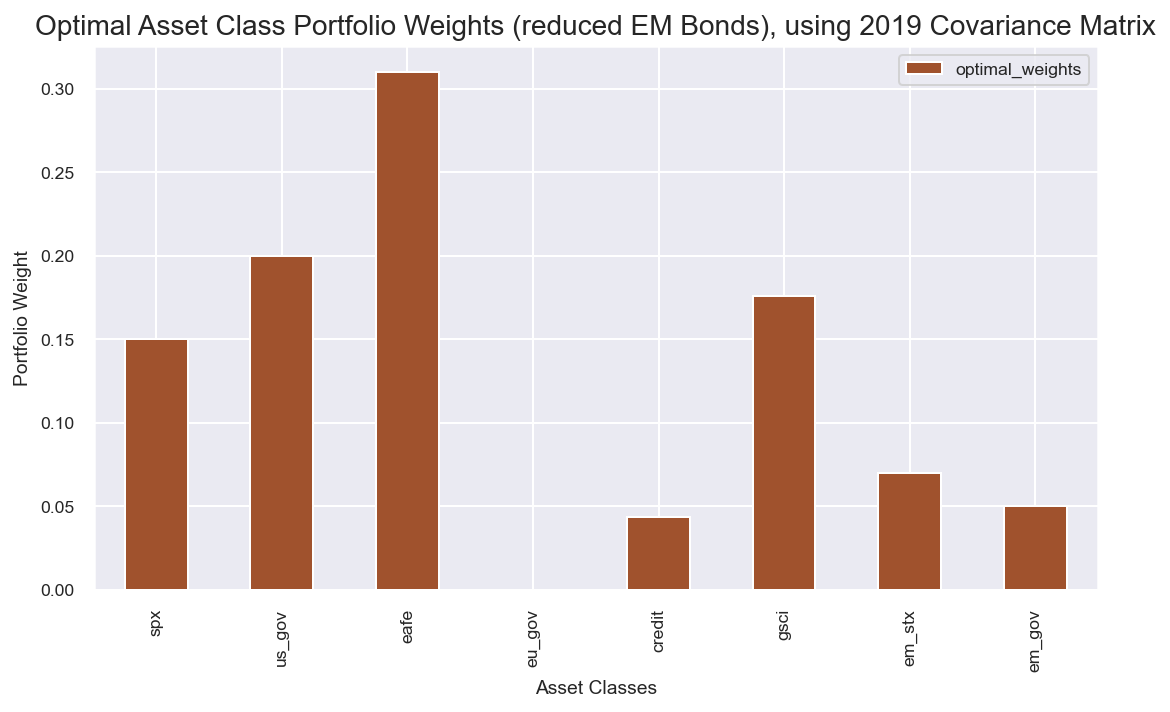

In [101]:
ax = opt_xem_2019.plot(kind='bar', color='sienna', figsize=(9, 5))
ax.set_xlabel("Asset Classes")
ax.set_ylabel("Portfolio Weight")
ax.set_title("Optimal Asset Class Portfolio Weights (reduced EM Bonds), using 2019 Covariance Matrix", fontsize=14)
plt.show()

In [102]:
r1_2019, s1_2019 = port_profile(opt_2019, expected_returns, cov_2019)
r2_2019, s2_2019 = port_profile(opt_xem_2019, expected_returns_xem, cov_xem_2019)

In [103]:
print(f"Expected return of all-asset portfolio: {r1_2019:0.6f}")
print(f"Expected return of ex-EM bonds portfolio: {r2_2019:0.6f}")
print(f"Standard deviation of all-asset portfolio: {s1_2019:0.6f}")
print(f"Standard deviation of ex-EM bonds portfolio: {s2_2019:0.6f}")

Expected return of all-asset portfolio: 0.045000
Expected return of ex-EM bonds portfolio: 0.045000
Standard deviation of all-asset portfolio: 0.050732
Standard deviation of ex-EM bonds portfolio: 0.063886


In [104]:
var_tests(df_port_2019, opt_2019, df_port_xem_2019, opt_xem_2019)

Null hypothesis of equal variances is rejected according to the F-test
F-test statistic: 1.585786
p-value: 0.000115
Null hypothesis of equal variances is rejected according to the Levene(median) test
Levene's test statistic: 7.497237
p-value: 0.006393
Null hypothesis of equal variances is rejected according to the Levene(trimmed) test
Levene's test statistic: 9.225870
p-value: 0.002520


In [105]:
#df_port.to_csv(r'C:\\Users\\camb7\\Documents\\Data projects\\China portfolio\\portfolio.csv', index=True)